# KNN Classification Model for Kickstarter Success Prediction

This notebook builds and evaluates K-Nearest Neighbors models to predict Kickstarter project success.

## Notebook Structure
1. **Setup & Data Loading** - Import libraries and load data
2. **Feature Engineering** - Prepare features for modeling
3. **Train/Test Split** - Create train and test sets
4. **Baseline Model** - Simple rule-based prediction
5. **Simple KNN Model** - KNN with default parameters
6. **Tuned KNN Model** - KNN with hyperparameter optimization
7. **Model Comparison** - Compare all models
8. **Conclusions**

---
## 1. Setup & Data Loading

In [27]:
# Initial imports
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# Sklearn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, f1_score, 
    roc_auc_score, precision_score, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Project path setup
curr_dir = Path.cwd()
project_root = curr_dir.parent.parent
sys.path.append(str(project_root))
print(f"Project Root: {project_root}")

from utils.feature_engineer_df import build_features, calculate_historical_success_rate

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

Project Root: d:\Programming\ai_ds_bootcamp\ds-ml-project_kickstarters


In [28]:
# Build features using our utils
build_features(
    input_path=Path.cwd().resolve().parents[1] / "data" / "cleaned" / "kickstarter_cleaned.csv",
    output_path=Path.cwd().resolve().parents[1] / "data" / "feature" / "kickstarter_featured.csv",
    raw_path=Path.cwd().resolve().parents[1] / "data" / "raw" / "ks-projects-201801.csv",
    logger=logger
)

# Load the featured dataset
BASE_DIR = Path.cwd().resolve().parents[1]
data_file = BASE_DIR / "data" / "feature" / "kickstarter_featured.csv"
df = pd.read_csv(data_file, encoding='latin-1', low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['target'].value_counts())

INFO:__main__:Starting feature engineering pipeline
INFO:__main__:Loaded 331675 rows
INFO:__main__:Final columns before save: ['id', 'main_category', 'deadline', 'launched', 'backers', 'country', 'usd_pledged_real', 'usd_goal_real', 'duration_days', 'target', 'main_category_grouped', 'continent', 'launched_year', 'launched_month', 'deadline_year', 'deadline_month', 'usd_goal_bins', 'usd_pledged_bins', 'pledged_per_category', 'goal_per_category', 'category_goal_percentile', 'duration_bins', 'backers_per_pledged', 'backer_pledged_bins', 'launch_season', 'deadline_season']
INFO:__main__:Saved engineered dataset to D:\Programming\ai_ds_bootcamp\ds-ml-project_kickstarters\data\feature\kickstarter_featured.csv


Dataset shape: (293019, 26)

Target distribution:
target
0    159063
1    133956
Name: count, dtype: int64


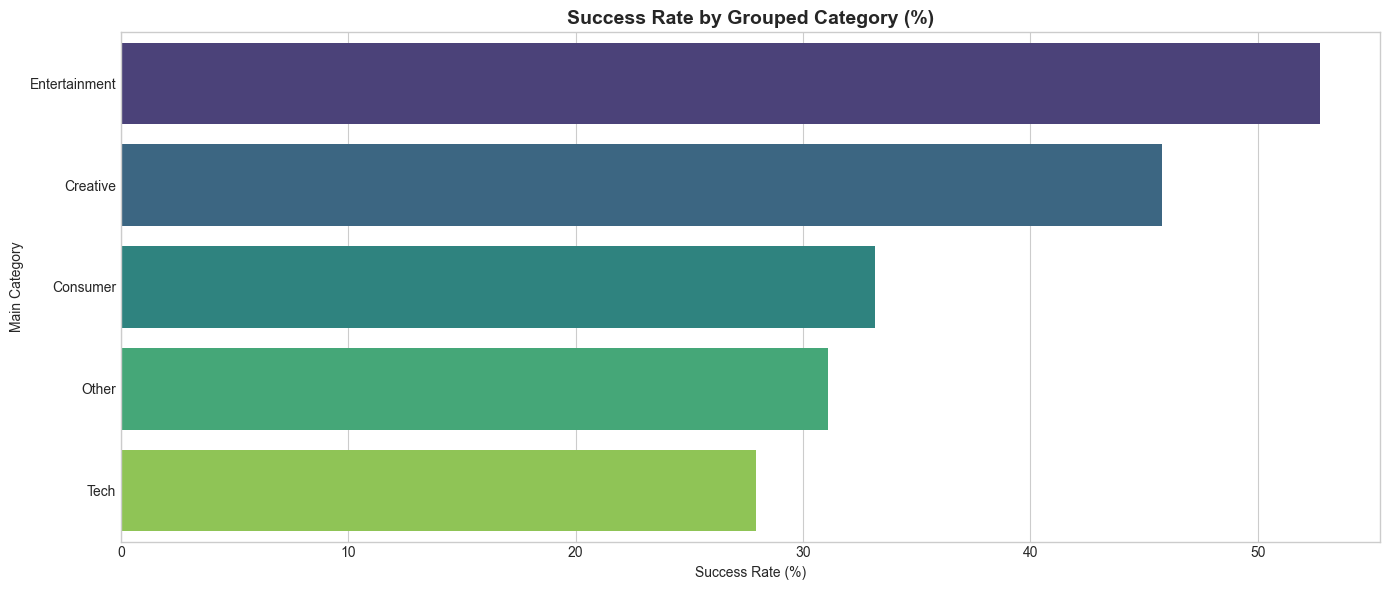

In [29]:
# 3. Success Rate by Grouped Category
category_success = df.groupby('main_category_grouped')['target'].apply(
    lambda x: (x == 1).sum() / len(x) * 100
).sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=category_success.values, y=category_success.index, palette='viridis')
plt.title('Success Rate by Grouped Category (%)', fontsize=14, fontweight='bold')
plt.xlabel('Success Rate (%)')
plt.ylabel('Main Category')
plt.tight_layout()
plt.show()

In [ ]:
# # Calculate the feature (4 weeks)
# df['hist_success_rate_4w'] = calculate_historical_success_rate(
#     df, 
#     category_col='main_category_grouped',
#     lookback_weeks=4
# )

# df['hist_success_rate_4w'] = df.groupby('main_category_grouped')['hist_success_rate_4w'].transform(
#     lambda x: x.fillna(x.mean())
# )

# # Check the result
# print(df[['main_category_grouped', 'launched', 'target', 'hist_success_rate_4w']].head(10))
# print(f"\nNaN count: {df['hist_success_rate_4w'].isna().sum()}")
# print(f"Mean rate: {df['hist_success_rate_4w'].mean():.2%}")

  main_category_grouped             launched  target  hist_success_rate_4w
0         Entertainment  2017-09-02 04:43:57       0              0.550000
1         Entertainment  2013-01-12 00:20:50       0              0.539258
2         Entertainment  2012-03-17 03:24:11       0              0.606080
3              Consumer  2016-02-26 13:38:27       1              0.283981
4              Consumer  2014-12-01 18:30:44       1              0.324242
5              Consumer  2016-02-01 20:05:12       0              0.272265
6         Entertainment  2013-03-09 06:42:58       1              0.581209
7         Entertainment  2017-04-05 19:44:18       1              0.548659
8              Creative  2015-01-29 02:10:53       0              0.313433
9              Creative  2014-10-09 22:27:52       0              0.378941

NaN count: 0
Mean rate: 45.76%


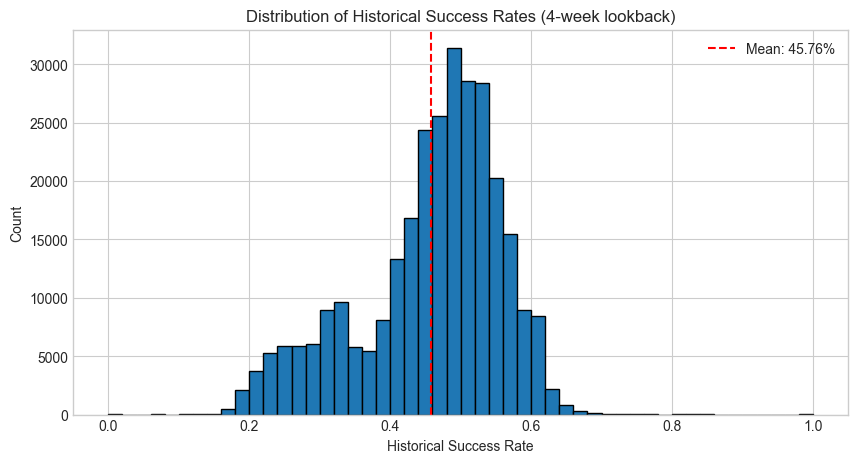

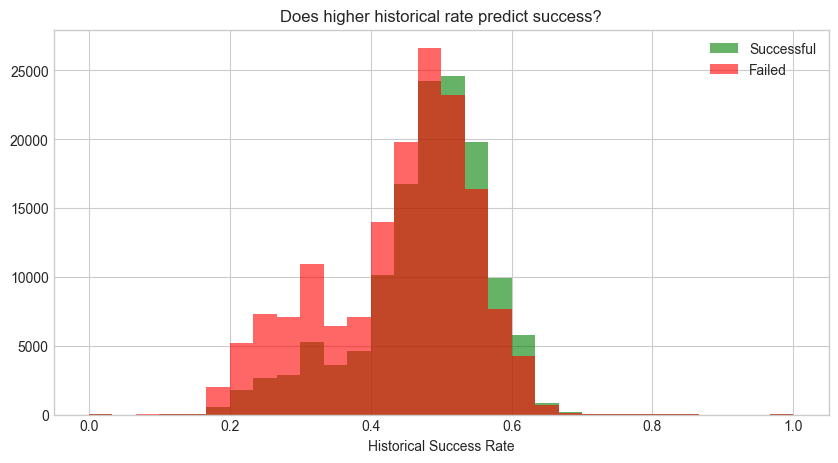

In [ ]:
# # --- 1. Distribution ---
# fig, ax = plt.subplots(figsize=(10, 5))
# df['hist_success_rate_4w'].dropna().hist(bins=50, ax=ax, edgecolor='black')
# ax.axvline(df['hist_success_rate_4w'].mean(), color='red', linestyle='--', label=f"Mean: {df['hist_success_rate_4w'].mean():.2%}")
# ax.set_xlabel('Historical Success Rate')
# ax.set_ylabel('Count')
# ax.set_title('Distribution of Historical Success Rates (4-week lookback)')
# ax.legend()
# plt.show()

# # --- 2. By outcome (most important - shows predictive power) ---
# fig, ax = plt.subplots(figsize=(10, 5))
# df[df['target']==1]['hist_success_rate_4w'].dropna().hist(bins=30, alpha=0.6, label='Successful', color='green', ax=ax)
# df[df['target']==0]['hist_success_rate_4w'].dropna().hist(bins=30, alpha=0.6, label='Failed', color='red', ax=ax)
# ax.set_xlabel('Historical Success Rate')
# ax.set_title('Does higher historical rate predict success?')
# ax.legend()
# plt.show()

---
## 2. Feature Engineering

In [33]:
# Columns to drop (irrelevant or contain future information)
columns_to_drop = [
    'id',                      # Irrelevant identifier
    'main_category',           # Will use grouped version
    'deadline', 'launched',    # Will use derived features
    'backers', 'usd_pledged_real', 'usd_pledged_bins',  # Future information (known after campaign)
    'backers_per_pledged', 'backer_pledged_bins', 'pledged_per_category',  # Future information
    'launched_year', 'deadline_year',  # Historical info, not seasonal
]

dfc = df.drop(columns=columns_to_drop)
print(f"Shape after dropping columns: {dfc.shape}")

Shape after dropping columns: (293019, 15)


In [34]:
# One-hot encoding for categorical variables (drop_first=True to avoid multicollinearity)
df_sl = pd.get_dummies(df['launch_season'], prefix='sl_', drop_first=True, dtype=int)
df_sd = pd.get_dummies(df['deadline_season'], prefix='sd_', drop_first=True, dtype=int)
df_cat = pd.get_dummies(df['main_category_grouped'], prefix='cat_', drop_first=True, dtype=int)
df_co = pd.get_dummies(df['continent'], prefix='co_', drop_first=True, dtype=int)

# Combine all features
dff = pd.concat([dfc, df_sl, df_sd, df_cat, df_co], axis=1)
print(f"Shape after encoding: {dff.shape}")

Shape after encoding: (293019, 28)


In [35]:
# Columns to soft-drop (redundant after encoding)
columns_to_softdrop = [
    'country',                  # Kept continent instead
    'main_category_grouped',    # Already encoded
    'continent',                # Already encoded
    'launched_month',           # Using season instead
    'deadline_month',           # Using season instead
    'usd_goal_bins',            # Using goal_per_category
    'category_goal_percentile', # Redundant with goal_per_category
    'duration_bins',            # Using actual duration_days
    'launch_season',            # Already encoded
    'deadline_season',          # Already encoded
]

df_to_scale = dff.drop(columns=columns_to_softdrop, axis=1)
print(f"Final features ({len(df_to_scale.columns)} columns):")
print(df_to_scale.columns.tolist())

Final features (18 columns):
['usd_goal_real', 'duration_days', 'target', 'goal_per_category', 'hist_success_rate_4w', 'sl__Spring', 'sl__Summer', 'sl__Winter', 'sd__Spring', 'sd__Summer', 'sd__Winter', 'cat__Creative', 'cat__Entertainment', 'cat__Other', 'cat__Tech', 'co__Europe', 'co__North America', 'co__Oceania']


---
## 3. Train/Test Split

In [36]:
# Create feature matrix and target
X = df_to_scale.drop(columns=['target'])
y = df_to_scale['target']

# Train-test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nFeatures: {X_train.shape[1]}")
print(f"\nClass balance in training set:")
print(y_train.value_counts())

Training set: 205,113 samples
Test set: 87,906 samples

Features: 17

Class balance in training set:
target
0    111344
1     93769
Name: count, dtype: int64


---
## 4. Baseline Model (Rule-Based)

Before applying machine learning, let's establish a simple baseline using domain knowledge.

**Baseline Rule**: Predict success (1) if the project belongs to Creative, Entertainment, or Tech categories (which may have higher success rates), otherwise predict failure (0).

In [37]:
# Define baseline model
top_cols = ['cat__Creative', 'cat__Entertainment']

def baseline_predict(row):
    """Simple rule-based prediction: success if in top categories"""
    if row[top_cols].sum() > 0:
        return 1
    else:
        return 0

# Apply baseline model to test set
y_pred_baseline = X_test.apply(baseline_predict, axis=1)

# Calculate baseline metrics
baseline_metrics = {
    'Model': 'Baseline (Category Rule)',
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline),
    'F1 Score': f1_score(y_test, y_pred_baseline),
    'ROC AUC': np.nan  # Cannot calculate AUC without probabilities
}

print("=" * 60)
print("BASELINE MODEL RESULTS")
print("=" * 60)
print(f"Rule: Predict success if project is in Creative, Entertainment, or Tech")
print()
for metric, value in baseline_metrics.items():
    if metric != 'Model':
        print(f"{metric:12}: {value:.4f}" if not np.isnan(value) else f"{metric:12}: N/A")

print(f"\nConfusion Matrix:")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(cm_baseline)

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Failed', 'Success']))

BASELINE MODEL RESULTS
Rule: Predict success if project is in Creative, Entertainment, or Tech

Accuracy    : 0.5367
Precision   : 0.4961
Recall      : 0.8578
F1 Score    : 0.6286
ROC AUC     : N/A

Confusion Matrix:
[[12706 35013]
 [ 5716 34471]]

Classification Report:
              precision    recall  f1-score   support

      Failed       0.69      0.27      0.38     47719
     Success       0.50      0.86      0.63     40187

    accuracy                           0.54     87906
   macro avg       0.59      0.56      0.51     87906
weighted avg       0.60      0.54      0.50     87906



---
## 5. Simple KNN Model (Default Parameters)

Now let's train a KNN model with default/reasonable parameters to see how much improvement ML provides over the baseline.

In [38]:
# Define column types for preprocessing
num_cols = ['usd_goal_real', 'duration_days', 'goal_per_category']
cat_cols = list(set(X.columns) - set(num_cols))

print(f"Numerical columns ({len(num_cols)}): {num_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)
    ]
)

Numerical columns (3): ['usd_goal_real', 'duration_days', 'goal_per_category']
Categorical columns (14): ['sd__Spring', 'cat__Other', 'cat__Creative', 'co__North America', 'co__Europe', 'sd__Summer', 'sl__Summer', 'hist_success_rate_4w', 'co__Oceania', 'cat__Tech', 'sl__Spring', 'cat__Entertainment', 'sl__Winter', 'sd__Winter']


In [39]:
# Simple KNN with default parameters
simple_knn = Pipeline([
    ("prep", preprocessor),
    ("knn", KNeighborsClassifier(
        n_neighbors=9,      # Default
        weights="uniform",  # Default
        metric="minkowski", # Default
        p=2                 # Euclidean distance
    ))
])

# Train the model
print("Training Simple KNN...")
simple_knn.fit(X_train, y_train)

# Predictions
y_pred_simple = simple_knn.predict(X_test)
y_proba_simple = simple_knn.predict_proba(X_test)[:, 1]

# Calculate metrics
simple_knn_metrics = {
    'Model': 'Simple KNN (k=9)',
    'Accuracy': accuracy_score(y_test, y_pred_simple),
    'Precision': precision_score(y_test, y_pred_simple),
    'Recall': recall_score(y_test, y_pred_simple),
    'F1 Score': f1_score(y_test, y_pred_simple),
    'ROC AUC': roc_auc_score(y_test, y_proba_simple)
}

print("\n" + "=" * 60)
print("SIMPLE KNN MODEL RESULTS")
print("=" * 60)
print(f"Parameters: n_neighbors=5, weights='uniform', metric='minkowski', p=2")
print()
for metric, value in simple_knn_metrics.items():
    if metric != 'Model':
        print(f"{metric:12}: {value:.4f}")

print(f"\nConfusion Matrix:")
cm_simple = confusion_matrix(y_test, y_pred_simple)
print(cm_simple)

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_simple, target_names=['Failed', 'Success']))

Training Simple KNN...

SIMPLE KNN MODEL RESULTS
Parameters: n_neighbors=5, weights='uniform', metric='minkowski', p=2

Accuracy    : 0.6086
Precision   : 0.5752
Recall      : 0.5500
F1 Score    : 0.5623
ROC AUC     : 0.6456

Confusion Matrix:
[[31395 16324]
 [18083 22104]]

Classification Report:
              precision    recall  f1-score   support

      Failed       0.63      0.66      0.65     47719
     Success       0.58      0.55      0.56     40187

    accuracy                           0.61     87906
   macro avg       0.60      0.60      0.60     87906
weighted avg       0.61      0.61      0.61     87906



---
## 6. Tuned KNN Model (Hyperparameter Optimization)

Now let's use RandomizedSearchCV to find optimal hyperparameters.

In [12]:
# Pipeline for tuning
tune_pipe = Pipeline([
    ("prep", preprocessor),
    ("knn", KNeighborsClassifier())
])

# Parameter distributions for RandomizedSearchCV
param_distributions = {
    "prep__num": [MinMaxScaler(), RobustScaler()],
    "knn__n_neighbors": [9, 11, 15, 17, 19, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__algorithm": ["auto"],
    "knn__metric": ["minkowski", "chebyshev"],
    "knn__p": [1, 2, 3],  # 1=Manhattan, 2=Euclidean, 3=Minkowski
}

print("Parameter search space:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

Parameter search space:
  prep__num: [MinMaxScaler(), RobustScaler()]
  knn__n_neighbors: [9, 11, 15, 17, 19, 21]
  knn__weights: ['uniform', 'distance']
  knn__algorithm: ['auto']
  knn__metric: ['minkowski', 'chebyshev']
  knn__p: [1, 2, 3]


In [13]:
# RandomizedSearchCV
rs = RandomizedSearchCV(
    tune_pipe,
    param_distributions,
    n_iter=30,
    cv=5,
    scoring="f1",
    n_jobs=4,
    random_state=42,
    verbose=1
)

print("Running RandomizedSearchCV (this may take a while)...")
rs.fit(X_train, y_train)
print("\nSearch complete!")

Running RandomizedSearchCV (this may take a while)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
# Best parameters found
print("=" * 60)
print("BEST PARAMETERS FOUND")
print("=" * 60)
for param, value in rs.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (ROC AUC): {rs.best_score_:.4f}")

In [ ]:
# Evaluate tuned model on test set
y_pred_tuned = rs.predict(X_test)
y_proba_tuned = rs.predict_proba(X_test)[:, 1]

# Calculate metrics
tuned_knn_metrics = {
    'Model': 'Tuned KNN (RandomizedSearchCV)',
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1 Score': f1_score(y_test, y_pred_tuned),
    'ROC AUC': roc_auc_score(y_test, y_proba_tuned)
}

print("\n" + "=" * 60)
print("TUNED KNN MODEL RESULTS")
print("=" * 60)
for metric, value in tuned_knn_metrics.items():
    if metric != 'Model':
        print(f"{metric:12}: {value:.4f}")

print(f"\nConfusion Matrix:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print(cm_tuned)

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Failed', 'Success']))

In [ ]:
# Cross-validation on best estimator for more robust evaluation
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
cv_scores = cross_validate(rs.best_estimator_, X_test, y_test, scoring=scoring, cv=5)

print("\nCross-Validation Scores on Test Set:")
print("-" * 40)
for metric in scoring:
    mean_score = cv_scores[f'test_{metric}'].mean()
    std_score = cv_scores[f'test_{metric}'].std()
    print(f"{metric:12}: {mean_score:.4f} (+/- {std_score:.4f})")

---
## 7. Model Comparison

In [ ]:
# Create comparison DataFrame
results_df = pd.DataFrame([baseline_metrics, simple_knn_metrics, tuned_knn_metrics])
results_df = results_df.set_index('Model')

# Style the DataFrame
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
display(results_df.style.format("{:.4f}", na_rep="N/A").highlight_max(axis=0, color='lightgreen'))

In [ ]:
# Calculate improvements
print("\nIMPROVEMENT ANALYSIS")
print("-" * 60)

# Simple KNN vs Baseline
print("\nSimple KNN vs Baseline:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    baseline_val = baseline_metrics[metric]
    simple_val = simple_knn_metrics[metric]
    improvement = (simple_val - baseline_val) / baseline_val * 100
    print(f"  {metric}: {improvement:+.2f}%")

# Tuned KNN vs Simple KNN
print("\nTuned KNN vs Simple KNN:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']:
    simple_val = simple_knn_metrics[metric]
    tuned_val = tuned_knn_metrics[metric]
    improvement = (tuned_val - simple_val) / simple_val * 100
    print(f"  {metric}: {improvement:+.2f}%")

### 7.1 Visualization: Metrics Comparison Bar Chart

In [ ]:
# Bar chart comparing metrics across models
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics_to_plot))
width = 0.25

# Plot bars for each model
bars1 = ax.bar(x - width, [baseline_metrics[m] for m in metrics_to_plot], 
               width, label='Baseline', color='#ff9999', edgecolor='black')
bars2 = ax.bar(x, [simple_knn_metrics[m] for m in metrics_to_plot], 
               width, label='Simple KNN', color='#66b3ff', edgecolor='black')
bars3 = ax.bar(x + width, [tuned_knn_metrics[m] for m in metrics_to_plot], 
               width, label='Tuned KNN', color='#99ff99', edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.2 Visualization: ROC Curves

In [ ]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

# Simple KNN ROC
fpr_simple, tpr_simple, _ = roc_curve(y_test, y_proba_simple)
auc_simple = roc_auc_score(y_test, y_proba_simple)
ax.plot(fpr_simple, tpr_simple, 'b-', linewidth=2, 
        label=f'Simple KNN (AUC = {auc_simple:.4f})')

# Tuned KNN ROC
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
auc_tuned = roc_auc_score(y_test, y_proba_tuned)
ax.plot(fpr_tuned, tpr_tuned, 'g-', linewidth=2, 
        label=f'Tuned KNN (AUC = {auc_tuned:.4f})')

# Random classifier baseline
ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier (AUC = 0.5000)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

### 7.3 Visualization: Precision-Recall Curves

In [ ]:
# Precision-Recall Curves
fig, ax = plt.subplots(figsize=(10, 8))

# Simple KNN PR
precision_simple, recall_simple, _ = precision_recall_curve(y_test, y_proba_simple)
pr_auc_simple = auc(recall_simple, precision_simple)
ax.plot(recall_simple, precision_simple, 'b-', linewidth=2, 
        label=f'Simple KNN (PR AUC = {pr_auc_simple:.4f})')

# Tuned KNN PR
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_proba_tuned)
pr_auc_tuned = auc(recall_tuned, precision_tuned)
ax.plot(recall_tuned, precision_tuned, 'g-', linewidth=2, 
        label=f'Tuned KNN (PR AUC = {pr_auc_tuned:.4f})')

# Baseline (proportion of positives)
baseline_pr = y_test.mean()
ax.axhline(y=baseline_pr, color='r', linestyle='--', linewidth=1, 
           label=f'Baseline (Positive Rate = {baseline_pr:.4f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

### 7.4 Visualization: Confusion Matrices

In [ ]:
# Confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cms = [cm_baseline, cm_simple, cm_tuned]
titles = ['Baseline Model', 'Simple KNN', 'Tuned KNN']

for ax, cm, title in zip(axes, cms, titles):
    # Normalize confusion matrix for percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Failed', 'Success'],
                yticklabels=['Failed', 'Success'])
    
    # Add percentages as secondary annotation
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.75, f'({cm_normalized[i, j]:.1%})',
                    ha='center', va='center', fontsize=9, color='gray')
    
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 7.5 Visualization: Hyperparameter Search Results

In [ ]:
# Analyze RandomizedSearchCV results
cv_results = pd.DataFrame(rs.cv_results_)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Score by number of neighbors
ax1 = axes[0, 0]
neighbor_scores = cv_results.groupby('param_knn__n_neighbors')['mean_test_score'].agg(['mean', 'std']).reset_index()
ax1.errorbar(neighbor_scores['param_knn__n_neighbors'], neighbor_scores['mean'], 
             yerr=neighbor_scores['std'], marker='o', capsize=5, linewidth=2, markersize=8)
ax1.set_xlabel('Number of Neighbors (k)', fontsize=11)
ax1.set_ylabel('Mean CV Score (ROC AUC)', fontsize=11)
ax1.set_title('Performance by Number of Neighbors', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. Score by weight type
ax2 = axes[0, 1]
sns.boxplot(x='param_knn__weights', y='mean_test_score', data=cv_results, ax=ax2, palette='Set2')
ax2.set_xlabel('Weight Type', fontsize=11)
ax2.set_ylabel('Mean CV Score (ROC AUC)', fontsize=11)
ax2.set_title('Performance by Weight Type', fontsize=12, fontweight='bold')

# 3. Score by scaler
ax3 = axes[1, 0]
cv_results['scaler_name'] = cv_results['param_prep__num'].astype(str).str.extract(r'([A-Za-z]+)Scaler')
sns.boxplot(x='scaler_name', y='mean_test_score', data=cv_results, ax=ax3, palette='Set3')
ax3.set_xlabel('Scaler Type', fontsize=11)
ax3.set_ylabel('Mean CV Score (ROC AUC)', fontsize=11)
ax3.set_title('Performance by Scaler', fontsize=12, fontweight='bold')

# 4. Score by p value (Minkowski distance parameter)
ax4 = axes[1, 1]
p_scores = cv_results.groupby('param_knn__p')['mean_test_score'].agg(['mean', 'std']).reset_index()
ax4.bar(p_scores['param_knn__p'].astype(str), p_scores['mean'], 
        yerr=p_scores['std'], capsize=5, color=['#ff9999', '#66b3ff', '#99ff99'], edgecolor='black')
ax4.set_xlabel('Minkowski p Parameter', fontsize=11)
ax4.set_ylabel('Mean CV Score (ROC AUC)', fontsize=11)
ax4.set_title('Performance by Distance Metric (p)', fontsize=12, fontweight='bold')
ax4.set_xticklabels(['p=1 (Manhattan)', 'p=2 (Euclidean)', 'p=3'])

plt.suptitle('Hyperparameter Search Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 8. Conclusions

In [ ]:
print("=" * 80)
print("CONCLUSIONS")
print("=" * 80)

print("\n1. MODEL PERFORMANCE SUMMARY:")
print("-" * 40)
print(f"   Baseline (Rule-Based):  F1={baseline_metrics['F1 Score']:.4f}")
print(f"   Simple KNN (k=5):       F1={simple_knn_metrics['F1 Score']:.4f}, ROC AUC={simple_knn_metrics['ROC AUC']:.4f}")
print(f"   Tuned KNN:              F1={tuned_knn_metrics['F1 Score']:.4f}, ROC AUC={tuned_knn_metrics['ROC AUC']:.4f}")

print("\n2. KEY FINDINGS:")
print("-" * 40)

# Compare models
best_model = max([('Baseline', baseline_metrics['F1 Score']),
                  ('Simple KNN', simple_knn_metrics['F1 Score']),
                  ('Tuned KNN', tuned_knn_metrics['F1 Score'])], key=lambda x: x[1])
print(f"   - Best performing model: {best_model[0]}")

# Improvement from baseline
baseline_f1 = baseline_metrics['F1 Score']
tuned_f1 = tuned_knn_metrics['F1 Score']
improvement = (tuned_f1 - baseline_f1) / baseline_f1 * 100
print(f"   - Tuned KNN improvement over baseline: {improvement:+.2f}% (F1 Score)")

# Tuning benefit
simple_auc = simple_knn_metrics['ROC AUC']
tuned_auc = tuned_knn_metrics['ROC AUC']
tuning_improvement = (tuned_auc - simple_auc) / simple_auc * 100
print(f"   - Hyperparameter tuning benefit: {tuning_improvement:+.2f}% (ROC AUC)")

print("\n3. BEST HYPERPARAMETERS FOUND:")
print("-" * 40)
for param, value in rs.best_params_.items():
    clean_param = param.replace('knn__', '').replace('prep__', '')
    print(f"   - {clean_param}: {value}")

print("\n4. RECOMMENDATIONS:")
print("-" * 40)
if tuned_auc < 0.65:
    print("   - KNN shows limited predictive power for this problem")
    print("   - Consider trying other algorithms (Random Forest, Gradient Boosting, etc.)")
    print("   - Feature engineering may need improvement")
else:
    print("   - KNN provides reasonable predictive performance")
    print("   - Consider ensemble methods to potentially improve further")

print("\n" + "=" * 80)

---
### Final Results Table

In [ ]:
# Display final comparison table
print("\nFinal Model Comparison:")
display(results_df.round(4))